In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from UliEngineering.EngineerIO import format_value
from si_prefix import si_format
import plecs_helper as helper
%matplotlib
%matplotlib inline

# Imports and setup
from pint import UnitRegistry
from scipy.signal import find_peaks
from scipy.optimize import fsolve

# pandas display using scientific notation
# pd.set_option('display.float_format', lambda x: f'{x:.3e}')

# use pint
units = UnitRegistry()
units.default_format = "~P.2f"

Using matplotlib backend: TkAgg


# Lab 12
### Ian Eykamp

The average power efficiency of our converter is 78%, which is very stable across input voltages and time. The efficiency decreases by less than 1% for input voltages between 18V and 13V. For an output power of 20W, the input power is around 25.5W, which means about 5.5W of power is lost. I get to gloat here that this matches my guesstimation from the pre-lab quite well.

In [59]:
Rload = 5 # Ohms
power_measurements = pd.read_csv("lab_12_efficiency.csv")
power_measurements["Pin (W)"] = power_measurements["Vin (V)"] * power_measurements["Iin (A)"]
power_measurements["Iout (A)"] = power_measurements["Vout (V)"] / Rload
power_measurements["Pout (W)"] = power_measurements["Vout (V)"] * power_measurements["Iout (A)"]
power_measurements["Efficiency (%)"] = power_measurements["Pout (W)"] / power_measurements["Pin (W)"] * 100
# power_measurements.drop(index = 5, inplace = True) # get rid of bogus last value which gave 120% efficiency
print(power_measurements)

   Gate drive resistor (Ohms)  Vin (V)  Iin (A)  Vout (V)  Pin (W)  Iout (A)  \
0                          33       18    1.399     10.07   25.182     2.014   
1                          22       18    1.394     10.07   25.092     2.014   
2                          15       18    1.384     10.07   24.912     2.014   

   Pout (W)  Efficiency (%)  
0  20.28098       80.537606  
1  20.28098       80.826479  
2  20.28098       81.410485  


The efficiency decreases monotonically with lower input voltage, but over the whole range of DCM operation, the efficiency only varies by less than 1%. Therefore, I conclude that the losses almost entirely depend on factors that are not input voltage-dependent.

4e-09
Your time constant is 190.60 ns
C_mosfet = 5.78 nF
Using C_mosfet = 5.75nF, the time constant should be R33Ohm * C5.75nF = 189.75 ns
Your time constant is 126.20 ns
C_mosfet = 5.74 nF
Using C_mosfet = 5.75nF, the time constant should be R22Ohm * C5.75nF = 126.50 ns
Your time constant is 91.60 ns
C_mosfet = 6.11 nF
Using C_mosfet = 5.75nF, the time constant should be R22Ohm * C5.75nF = 86.25 ns


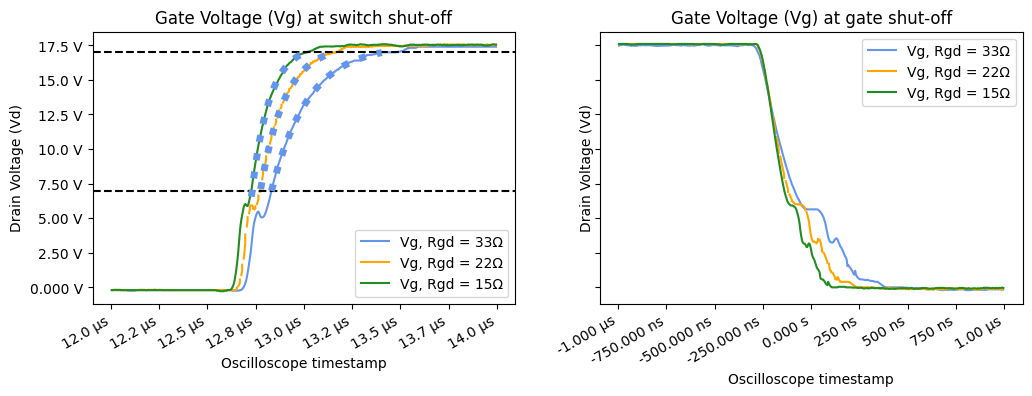

In [127]:
# Vd
(df_33, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/Rgdr_33_Ohm.csv", ch1 = "Vsh_33", ch2 = "Vd_33", ch3 = "Vg_33", ch4 = "Vgdr_33", shift = 0.19e-6)
(df_22, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/Rgdr_22_Ohm.csv", ch1 = "Vsh_22", ch2 = "Vd_22", ch3 = "Vg_22", ch4 = "Vgdr_22")
(df_15, tspan, tstep) = helper.read_rigol_csv("oscilloscope_data/Rgdr_15_Ohm.csv", ch1 = "Vsh_15", ch2 = "Vd_15", ch3 = "Vg_15", ch4 = "Vgdr_15", shift = -50e-9)
df = df_33.set_index("t").join([df_22.set_index("t"), df_15.set_index("t")]).reset_index()
print(tstep)
df_hf_zoom = df[(df["t"] > 12e-6) & (df["t"] < 14e-6)]
df_lf_zoom = df[(df["t"] > -1e-6) & (df["t"] < 1e-6)]

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, sharex = False, sharey = True, figsize = (12, 4))
fig.autofmt_xdate()
helper.axes_labels("Oscilloscope timestamp", "s", "Drain Voltage (Vd)", "V", title = "Gate Voltage (Vg) at switch shut-off", ax = ax1)
ax1.plot(df_hf_zoom["t"], df_hf_zoom["Vg_33"], color = "cornflowerblue", label = "Vg, Rgd = 33Ω")
ax1.plot(df_hf_zoom["t"], df_hf_zoom["Vg_22"], color = "orange", label = "Vg, Rgd = 22Ω")
ax1.plot(df_hf_zoom["t"], df_hf_zoom["Vg_15"], color = "forestgreen", label = "Vg, Rgd = 15Ω")
ax1.axhline(7, linestyle = "dashed", color = "black")
ax1.axhline(17, linestyle = "dashed", color = "black")
# ax1.plot(df_hf_zoom["t"], df_hf_zoom["Vgdr_33"], color = "cornflowerblue", linestyle = "dashed", label = "Vgdr, Rgd = 33Ω")
# ax1.plot(df_hf_zoom["t"], df_hf_zoom["Vgdr_22"], color = "orange", linestyle = "dashed", label = "Vgdr, Rgd = 22Ω")
# ax1.plot(df_hf_zoom["t"], df_hf_zoom["Vgdr_15"], color = "forestgreen", linestyle = "dashed", label = "Vgdr, Rgd = 15Ω")
ax1.legend(loc = "lower right")

helper.axes_labels("Oscilloscope timestamp", "s", "Drain Voltage (Vd)", "V", title = "Gate Voltage (Vg) at gate shut-off", ax = ax2)
ax2.plot(df_lf_zoom["t"], df_lf_zoom["Vg_33"], color = "cornflowerblue", label = "Vg, Rgd = 33Ω")
ax2.plot(df_lf_zoom["t"], df_lf_zoom["Vg_22"], color = "orange", label = "Vg, Rgd = 22Ω")
ax2.plot(df_lf_zoom["t"], df_lf_zoom["Vg_15"], color = "forestgreen", label = "Vg, Rgd = 15Ω")
# ax2.plot(df_lf_zoom["t"], df_lf_zoom["Vgdr_33"], color = "cornflowerblue", linestyle = "dashed", label = "Vgdr, Rgd = 33Ω")
# ax2.plot(df_lf_zoom["t"], df_lf_zoom["Vgdr_22"], color = "orange", linestyle = "dashed", label = "Vgdr, Rgd = 22Ω")
# ax2.plot(df_lf_zoom["t"], df_lf_zoom["Vgdr_15"], color = "forestgreen", linestyle = "dashed", label = "Vgdr, Rgd = 15Ω")
ax2.legend(loc = "upper right")

# C_mosfet = 190 * units.nanosecond / (33 * units.ohm)
# print(f"Assuming C = {C_mosfet.to_compact(units.farad)}")
# C_mosfet = 126 * units.nanosecond / (22 * units.ohm)
# print(f"Assuming C = {C_mosfet.to_compact(units.farad)}")
# C_mosfet = 91 * units.nanosecond / (15 * units.ohm)
# print(f"Assuming C = {C_mosfet.to_compact(units.farad)}")

def get_upward_time_constant(var_x, var_y, asymptote):
    x_log = var_x
    y_log = np.log(asymptote - var_y)
    A = np.vstack([x_log, np.ones(len(x_log))]).T
    a, b = np.linalg.lstsq(A, y_log, rcond=None)[0]
    y_back = asymptote - np.exp(a * var_x + b)
    # print(f"Your time constant is {units.Quantity(-1 / a, units.second).to_compact()}")
    # print(f"Using R * C and C = 6nF, then tau = {}")
    return (var_x, y_back, a)

C_nominal = 5.75 * units.nanofarad

x_range_33 = (df_hf_zoom["Vg_33"] > 7) & (df_hf_zoom["Vg_33"] < 17)
(x_back_33, y_back_33, a_exp) = get_upward_time_constant(df_hf_zoom["t"][x_range_33], df_hf_zoom["Vg_33"][x_range_33], asymptote = 17.5)
ax1.plot(x_back_33, y_back_33, color = "cornflowerblue", linestyle = "dotted", linewidth = 5, label = "Vg, Rgd = 33Ω")
time_constant = units.Quantity(-1 / a_exp, units.second)
print(f"Your time constant is {time_constant.to_compact(units.second)}")
C_mosfet = time_constant / (33 * units.ohm)
print(f"C_mosfet = {C_mosfet.to_compact(units.farad)}")
print(f"Using C_mosfet = 5.75nF, the time constant should be R33Ohm * C5.75nF = {(33 * units.ohm * C_nominal).to_compact(units.second)}")


x_range_22 = (df_hf_zoom["Vg_22"] > 7) & (df_hf_zoom["Vg_22"] < 17)
(x_back_22, y_back_22, a_exp) = get_upward_time_constant(df_hf_zoom["t"][x_range_22], df_hf_zoom["Vg_22"][x_range_22], asymptote = 17.5)
ax1.plot(x_back_22, y_back_22, color = "cornflowerblue", linestyle = "dotted", linewidth = 5, label = "Vg, Rgd = 22Ω")
time_constant = units.Quantity(-1 / a_exp, units.second)
print(f"Your time constant is {time_constant.to_compact(units.second)}")
C_mosfet = time_constant / (22 * units.ohm)
print(f"C_mosfet = {C_mosfet.to_compact(units.farad)}")
print(f"Using C_mosfet = 5.75nF, the time constant should be R22Ohm * C5.75nF = {(22 * units.ohm * C_nominal).to_compact(units.second)}")

x_range_15 = (df_hf_zoom["Vg_15"] > 7) & (df_hf_zoom["Vg_15"] < 17)
(x_back_15, y_back_15, a_exp) = get_upward_time_constant(df_hf_zoom["t"][x_range_15], df_hf_zoom["Vg_15"][x_range_15], asymptote = 17.5)
ax1.plot(x_back_15, y_back_15, color = "cornflowerblue", linestyle = "dotted", linewidth = 5, label = "Vg, Rgd = 15Ω")
time_constant = units.Quantity(-1 / a_exp, units.second)
print(f"Your time constant is {time_constant.to_compact(units.second)}")
C_mosfet = time_constant / (15 * units.ohm)
print(f"C_mosfet = {C_mosfet.to_compact(units.farad)}")
print(f"Using C_mosfet = 5.75nF, the time constant should be R22Ohm * C5.75nF = {(15 * units.ohm * C_nominal).to_compact(units.second)}")


## Oscilloscope Data

My axes are none!!!
Power Losses
--------
Full Cycle Power Loss: 4.51 W
--------
MOSFET Shut-off Power Loss: 1.04 W
Diode Shut-off Power Loss: 566.84 mW
MOSFET Turn-on Power Loss: 141.25 mW
Power Losses
--------
Full Cycle Power Loss: 3.10 W
--------
MOSFET Shut-off Power Loss: 767.47 mW
Diode Shut-off Power Loss: 166.54 mW
MOSFET Turn-on Power Loss: 142.60 mW
Power Losses
--------
Full Cycle Power Loss: 2.95 W
--------
MOSFET Shut-off Power Loss: 770.81 mW
Diode Shut-off Power Loss: 112.73 mW
MOSFET Turn-on Power Loss: 143.56 mW


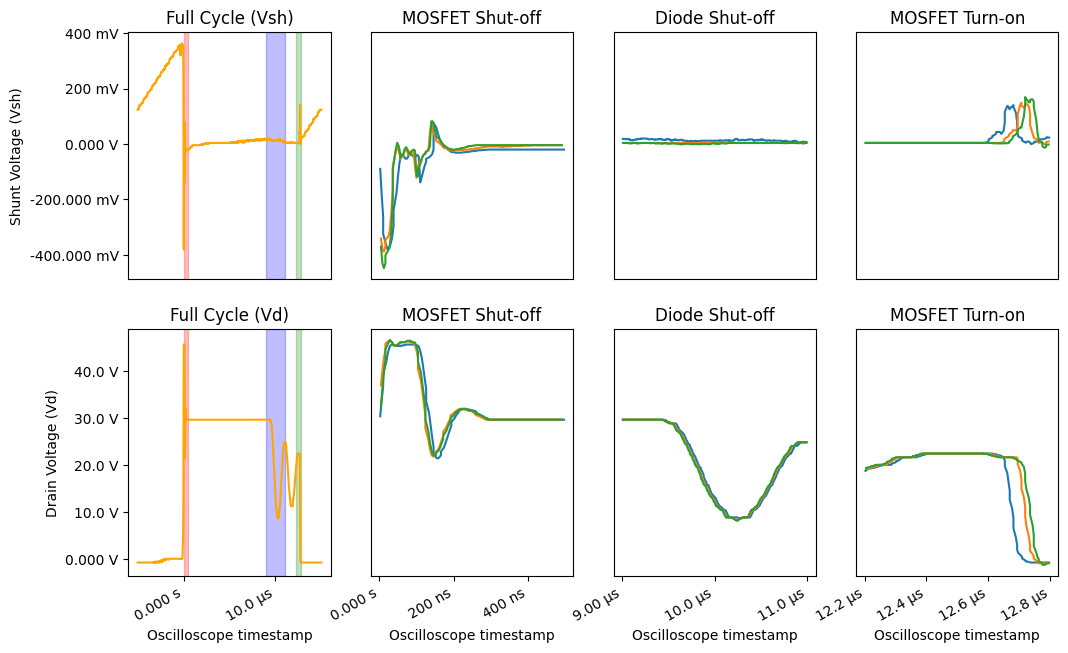

In [60]:
def plot_regions(cycle_ts, cycle_ts_name, switch_off_ts, switch_off_ts_name, diode_off_ts, diode_off_ts_name, switch_on_ts, switch_on_ts_name, my_axes = None, filename = "oscilloscope_data/NewFile7.csv", time_shift = 0):

    (df_18V, tspan, tstep) = helper.read_rigol_csv(filename, ch1 = "Vsh", ch2 = "Vd", ch3 = "Vg", ch4 = "Vgdr")
    df_18V["Vsh"] = df_18V["Vsh"] + 12e-3 # V measuring offset
    df_18V["t"] = df_18V["t"] + time_shift

    df_zoom           = df_18V[(df_18V["t"] > cycle_ts[0]) & (df_18V["t"] < cycle_ts[1])]
    df_zoom_switch_off = df_18V[(df_18V["t"] > switch_off_ts[0]) & (df_18V["t"] < switch_off_ts[1])]
    df_zoom_diode_off = df_18V[(df_18V["t"] > diode_off_ts[0]) & (df_18V["t"] < diode_off_ts[1])]
    df_zoom_switch_on = df_18V[(df_18V["t"] > switch_on_ts[0]) & (df_18V["t"] < switch_on_ts[1])]

    my_alpha = 0.25
    if my_axes is None:
        print("My axes are none!!!")
        fig, your_axes = plt.subplots(nrows = 2, ncols = 4, sharex = False, sharey = False, figsize = (12, 8))
        ((ax11, ax12, ax13, ax14), (ax21, ax22, ax23, ax24)) = your_axes
        fig.autofmt_xdate()
        helper.axes_labels("Oscilloscope timestamp", "s", "Shunt Voltage (Vsh)", "V", title = cycle_ts_name + " (Vsh)", ax = ax11)
        ax11.plot(df_zoom["t"], df_zoom["Vsh"], color = "orange")
        ax11.axvspan(switch_off_ts[0], switch_off_ts[1], color = 'red', alpha = my_alpha)
        ax11.axvspan(diode_off_ts[0], diode_off_ts[1], color = 'blue', alpha = my_alpha)
        ax11.axvspan(switch_on_ts[0], switch_on_ts[1], color = 'green', alpha = my_alpha)
        
        helper.axes_labels("Oscilloscope timestamp", "s", "Drain Voltage (Vd)", "V", title = cycle_ts_name + " (Vd)", ax = ax21)
        ax21.plot(df_zoom["t"], df_zoom["Vd"], color = "orange")
        ax21.axvspan(switch_off_ts[0], switch_off_ts[1], color = 'red', alpha = my_alpha)
        ax21.axvspan(diode_off_ts[0], diode_off_ts[1], color = 'blue', alpha = my_alpha)
        ax21.axvspan(switch_on_ts[0], switch_on_ts[1], color = 'green', alpha = my_alpha)
    else: 
        ((ax11, ax12, ax13, ax14), (ax21, ax22, ax23, ax24)) = my_axes

    helper.axes_labels("Oscilloscope timestamp", "s", "Shunt Voltage (Vsh)", "V", title = switch_off_ts_name, ax = ax12)
    ax12.plot(df_zoom_switch_off["t"], df_zoom_switch_off["Vsh"])
    # ax12.axvline(x = 0e-6, linestyle = "dashed", color = "black")

    helper.axes_labels("Oscilloscope timestamp", "s", "Shunt Voltage (Vsh)", "V", title = diode_off_ts_name, ax = ax13)
    ax13.plot(df_zoom_diode_off["t"], df_zoom_diode_off["Vsh"])

    helper.axes_labels("Oscilloscope timestamp", "s", "Shunt Voltage (Vsh)", "V", title = switch_on_ts_name, ax = ax14)
    ax14.plot(df_zoom_switch_on["t"], df_zoom_switch_on["Vsh"])


    helper.axes_labels("Oscilloscope timestamp", "s", "Drain Voltage (Vd)", "V", title = switch_off_ts_name, ax = ax22)
    ax22.plot(df_zoom_switch_off["t"], df_zoom_switch_off["Vd"])
    # ax22.axvline(x = 0e-6, linestyle = "dashed", color = "black")

    helper.axes_labels("Oscilloscope timestamp", "s", "Drain Voltage (Vd)", "V", title = diode_off_ts_name, ax = ax23)
    ax23.plot(df_zoom_diode_off["t"], df_zoom_diode_off["Vd"])

    helper.axes_labels("Oscilloscope timestamp", "s", "Drain Voltage (Vd)", "V", title = switch_on_ts_name, ax = ax24)
    ax24.plot(df_zoom_switch_on["t"], df_zoom_switch_on["Vd"])

    # ax11.get_shared_y_axes().join(ax11, ax12, ax14)
    ax11.get_shared_y_axes().join(ax11, ax12, ax13, ax14)
    ax21.get_shared_y_axes().join(ax21, ax22, ax23, ax24)
    ax12.get_yaxis().set_visible(False)
    ax13.get_yaxis().set_visible(False)
    ax14.get_yaxis().set_visible(False)
    ax11.get_xaxis().set_visible(False)
    ax12.get_xaxis().set_visible(False)
    ax13.get_xaxis().set_visible(False)
    ax14.get_xaxis().set_visible(False)
    ax22.get_yaxis().set_visible(False)
    ax23.get_yaxis().set_visible(False)
    ax24.get_yaxis().set_visible(False)

    def abs_or_not(x):
        # return x
        return np.abs(x)

    print("Power Losses")
    print("--------")
    # df_lf_trapz = df_zoom[np.logical_not(np.isnan(df_zoom["Vsh_hf_snub_lf"]))]
    cycle_switch_area = np.trapz(abs_or_not(df_zoom["Vsh"]) * abs_or_not(df_zoom["Vd"]), df_zoom["t"])
    print(f"{cycle_ts_name} Power Loss:", (cycle_switch_area * units.volt ** 2 * units.second / (0.05 * units.ohm) * 50 * units.kilohertz).to_compact(units.watt))
    print("--------")
    switch_off_area = np.trapz(abs_or_not(df_zoom_switch_off["Vsh"]) * abs_or_not(df_zoom_switch_off["Vd"]), df_zoom_switch_off["t"])
    print(f"{switch_off_ts_name} Power Loss:", (switch_off_area * units.volt ** 2 * units.second / (0.05 * units.ohm) * 50 * units.kilohertz).to_compact(units.watt))
    diode_off_area = np.trapz(abs_or_not(df_zoom_diode_off["Vsh"]) * abs_or_not(df_zoom_diode_off["Vd"]), df_zoom_diode_off["t"])
    print(f"{diode_off_ts_name} Power Loss:", (diode_off_area * units.volt ** 2 * units.second / (0.05 * units.ohm) * 50 * units.kilohertz).to_compact(units.watt))
    switch_on_area = np.trapz(abs_or_not(df_zoom_switch_on["Vsh"]) * abs_or_not(df_zoom_switch_on["Vd"]), df_zoom_switch_on["t"])
    print(f"{switch_on_ts_name} Power Loss:", (switch_on_area * units.volt ** 2 * units.second / (0.05 * units.ohm) * 50 * units.kilohertz).to_compact(units.watt))
    if my_axes is None:
        return your_axes
    return my_axes


cycle_ts = (-5e-6, 15e-6)
# switch_off_ts = (-0.2e-6, 0.2e-6)
switch_off_ts = (-0e-6, 0.5e-6)
diode_off_ts = (9e-6, 11e-6)
switch_on_ts = (12.2e-6, 12.8e-6)

my_axes = plot_regions(
        cycle_ts = cycle_ts, cycle_ts_name = "Full Cycle",
        switch_off_ts = switch_off_ts, switch_off_ts_name = "MOSFET Shut-off", 
        diode_off_ts = diode_off_ts, diode_off_ts_name = "Diode Shut-off", 
        switch_on_ts = switch_on_ts, switch_on_ts_name = "MOSFET Turn-on", 
        my_axes = None, filename = "oscilloscope_data/Rgdr_33_Ohm.csv", time_shift = 110e-9
)
my_axes = plot_regions(
        cycle_ts = cycle_ts, cycle_ts_name = "Full Cycle",
        switch_off_ts = switch_off_ts, switch_off_ts_name = "MOSFET Shut-off", 
        diode_off_ts = diode_off_ts, diode_off_ts_name = "Diode Shut-off", 
        switch_on_ts = switch_on_ts, switch_on_ts_name = "MOSFET Turn-on", 
        my_axes = my_axes, filename = "oscilloscope_data/Rgdr_22_Ohm.csv"
)
my_axes = plot_regions(
        cycle_ts = cycle_ts, cycle_ts_name = "Full Cycle",
        switch_off_ts = switch_off_ts, switch_off_ts_name = "MOSFET Shut-off", 
        diode_off_ts = diode_off_ts, diode_off_ts_name = "Diode Shut-off", 
        switch_on_ts = switch_on_ts, switch_on_ts_name = "MOSFET Turn-on", 
        my_axes = my_axes, filename = "oscilloscope_data/Rgdr_15_Ohm.csv"
)
my_axes = None

In the above plots, I isolated various regions of the switching cycle. The MOSFET current is the shunt voltage divided by the shunt resistor, $\frac{V_{sh}}{R_{shunt}} = I$. For each region, the integral of the power $P = I(t) \cdot V_d(t)$ is taken and reported above the figure (multiplied by the switching frequency). The regions were chosen to isolate the switching losses from the cycle.

I had to add a constant offset of 12mV to the `Vsh` voltage. Otherwise, the shunt voltage was not centered at 0V even when the MOSFET was off, leading to large errors in my power integration results. I attribute the 12mV difference to measurement error, and I assume the actual leakage current to be negligible (on the order of pA).

The MOSFET turn-off switching loss is around 700mW, which dominates the MOSFET power loss of ~1W total (estimating based on positive and negative power dissipation values). The MOSFET turn-on switching loss is only around 100mW, which is much smaller. This is expected because we are in Discontinuous Conduction Mode (DCM), which means the current is negligible at the time we turn the switch on.

My axes are none!!!
Power Losses
--------
Full Cycle Power Loss: 4.49 W
--------
Diode Is On Power Loss: 1.16 W
Diode Is Off Power Loss: 426.26 mW
MOSFET Is On Power Loss: 507.26 mW
Power Losses
--------
Full Cycle Power Loss: 3.08 W
--------
Diode Is On Power Loss: 707.11 mW
Diode Is Off Power Loss: 212.62 mW
MOSFET Is On Power Loss: 687.38 mW
Power Losses
--------
Full Cycle Power Loss: 3.01 W
--------
Diode Is On Power Loss: 663.77 mW
Diode Is Off Power Loss: 155.19 mW
MOSFET Is On Power Loss: 744.56 mW


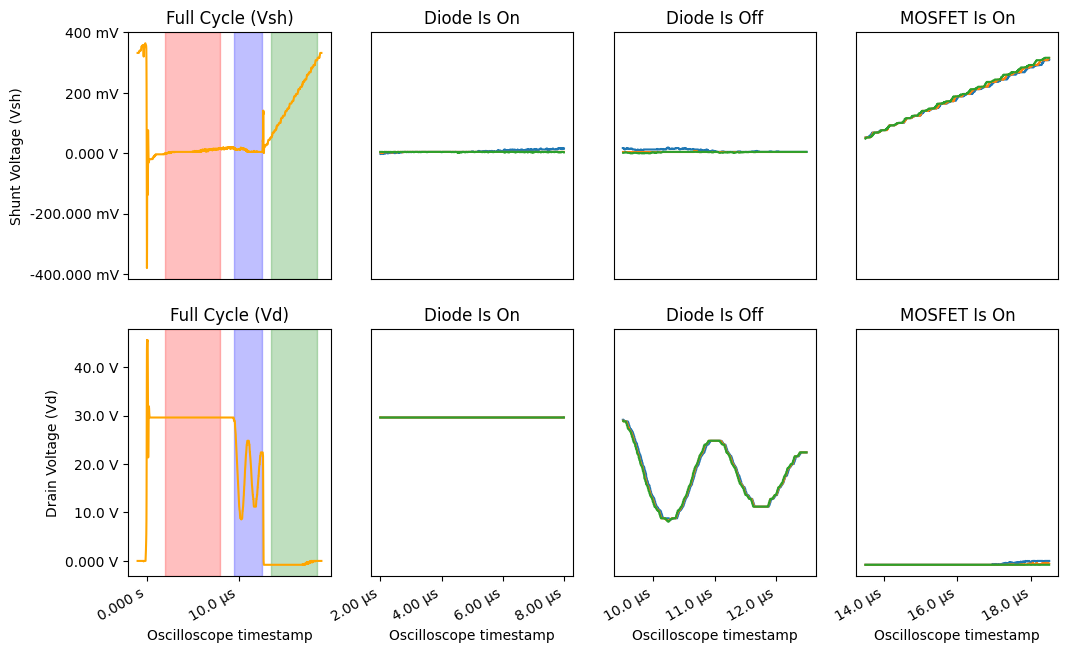

In [61]:
cycle_ts = (-1e-6, 19e-6)
diode_is_on_ts = (2e-6, 8e-6)
diode_is_off_ts = (9.5e-6, 12.5e-6)
switch_is_on_ts = (13.5e-6, 18.5e-6)

my_axes = plot_regions(
        cycle_ts = cycle_ts, cycle_ts_name = "Full Cycle", 
        switch_off_ts = diode_is_on_ts, switch_off_ts_name = "Diode Is On", 
        diode_off_ts = diode_is_off_ts, diode_off_ts_name = "Diode Is Off", 
        switch_on_ts = switch_is_on_ts, switch_on_ts_name = "MOSFET Is On", 
        my_axes = None, filename = "oscilloscope_data/Rgdr_33_Ohm.csv", time_shift = 110e-9
)
my_axes = plot_regions(
        cycle_ts = cycle_ts, cycle_ts_name = "Full Cycle", 
        switch_off_ts = diode_is_on_ts, switch_off_ts_name = "Diode Is On", 
        diode_off_ts = diode_is_off_ts, diode_off_ts_name = "Diode Is Off", 
        switch_on_ts = switch_is_on_ts, switch_on_ts_name = "MOSFET Is On", 
        my_axes = my_axes, filename = "oscilloscope_data/Rgdr_22_Ohm.csv"
)
my_axes = plot_regions(
        cycle_ts = cycle_ts, cycle_ts_name = "Full Cycle", 
        switch_off_ts = diode_is_on_ts, switch_off_ts_name = "Diode Is On", 
        diode_off_ts = diode_is_off_ts, diode_off_ts_name = "Diode Is Off", 
        switch_on_ts = switch_is_on_ts, switch_on_ts_name = "MOSFET Is On", 
        my_axes = my_axes, filename = "oscilloscope_data/Rgdr_15_Ohm.csv"
)
my_axes = None

Similarly, the non-switching regions have minimal power dissipation despite making up a much larger fraction of the switching cycle.

In addition, the shunt resistor dissipates power whenever current flows through it by $P_{sh} = V_{sh}^2 / I$. Taking the integral of $P_{sh}(t)$ over an entire switching cycle and multiplying by the switching frequency yields around 400mV.

In [62]:
cycle_ts = (-5e-6, 15e-6)

(df_18V, tspan, tstep) = helper.read_rigol_csv(f"oscilloscope_data/{filenames[0]}.csv", ch1 = "Vsh", ch2 = "Vd")
df_18V["Vsh"] = df_18V["Vsh"] + 12e-3 # V measuring offset
df_zoom = df_18V[(df_18V["t"] > cycle_ts[0]) & (df_18V["t"] < cycle_ts[1])]

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, sharex = False, sharey = False, figsize = (12, 4))
fig.autofmt_xdate()
helper.axes_labels("Oscilloscope timestamp", "s", "Shunt Voltage (Vsh)", "V", title = "Shunt Voltage (Vsh)", ax = ax1)
ax1.plot(df_zoom["t"], df_zoom["Vsh"], color = "orange", label = "Shunt Voltage (Vsh)")
ax1.legend(loc = "lower right")

helper.axes_labels("Oscilloscope timestamp", "s", "MOSFET Drain Voltage (Vd)", "V", title = "MOSFET Drain Voltage (Vd)", ax = ax2)
ax2.plot(df_zoom["t"], df_zoom["Vd"], label = "Drain Voltage (Vd)")
ax2.legend(loc = "lower right")

Rload = 0.05 # Ohm
cycle_switch_area = np.trapz(df_zoom["Vsh"] ** 2 / Rload, df_zoom["t"])
print(f"Shunt Resistor Power Loss:", (cycle_switch_area * units.volt ** 2 * units.second / units.ohm * 50 * units.kilohertz).to_compact(units.watt))

diode_on_duration = 9.5e-6 # s
ax2.axvline(x = 0, linestyle = "dashed", color = "black")
ax2.axvline(x = diode_on_duration, linestyle = "dashed", color = "black")

NameError: name 'filenames' is not defined

In [ ]:
delta_V = 15 * units.volt
Rsnubber = 10 * units.ohm
R_AC = 4.47 * units.ohm
P_per_cycle = delta_V ** 2 / (Rsnubber + R_AC)
W_per_cycle = P_per_cycle * 200 * units.nanosecond
P_overall =  W_per_cycle * 50 * units.kilohertz
print("Snubber + AC Resistance Power Dissipation:", P_overall.to_compact(units.watt))

V_F = 0.68 * units.volt
I_D = 2 * units.amp
P_D_per_cycle = V_F * I_D
P_D = P_D_per_cycle * diode_on_duration * units.second * 50 * units.kilohertz
print("Diode Power Dissipation:", P_D.to_compact(units.watt))

## Putting It All Together

We have to account for 5.5W of power dissipation. We have close to 1W of switching loss from the MOSFET turn-off and 400mV from the shunt resistor. For Lab 7, the clamp design calculations involved estimating the energy stored in the leakage inductance that would need to be dissipated each cycle. This yielded close to 1W, after scaling by the clamp voltage ratio (since more energy is dissipated by the clamp than is stored in the leakage inductance). I do not know if this quantity includes energy dissipated by the snubber, clamp, and AC resistance together.

During the high-frequency ringing, the snubber brings the ringing down from the clamp voltage to the steady-state drain voltage in a matter of 200ns. The voltage drop is 15V, the snubber resistor is $10 \Omega$ in series with an AC resistance of $4.47 \Omega$ for high frequency calculated in Lab 7, and the power dissipation is $P = \Delta V^2/(R_{snubber} + R_{AC}) \approx 155mW$. This is a small enough quantity that it may be either neglected or treated as part of the leakage inductance power dissipation accounted for under the clamp.

From prior work, I estimated the magnetic losses due to hysteresis to be around 90mW.

The output current is 2A on average. The forward voltage across the diode is 0.68V. Therefore, the diode dissipates $P = I_D V_F$ when it carries forward current. The diode only carries current between the time when the MOSFET turns off and when the inductor runs out of current. For our operating conditions, this works out to about 9.5us per switching cycle (vertical bars in the graph above). Overall, the diode dissipates around 600mW.

### FLIR Images
![FLIR Image 100 (thermal spectrum camera)](flir_images/FLIR0100.jpg)
![FLIR Image 101 (visible spectrum camera)](flir_images/FLIR0101.jpg)

From the FLIR images, the hotspots are on the components already identified, such as the MOSFET, diode, and transformer. The leakage inductance should not be producing heat in the transformer itself; the energy should mostly be dissipated in the snubber and clamp components. Perhaps I underestimated the winding resistance and AC resistance which occurs in the transformer itself. The transformer has a large thermal mass, so it must be dissipating a large amount of heat for its temperature to rise so much. By comparison, the diode gets very hot because it is one component dissipating around 600mW of power, without the aid of a heat sink. However, the diode always remains within its temperature operating conditions (150degrees C) according to the datasheet.

### Power Dissipation Pie Chart

In [ ]:
power_losses = pd.DataFrame({
    "Switching Loss": 1020, 
    "Leakage Inductance": 984.03, 
    "Diode When On": 646, 
    "Shunt Resistor": 402.97, 
    "Snubber + AC": 155.49, 
    "Magnetic Hysteresis": 90, 
}, index = ["Loss (mW)"]).transpose()

total_calculated_losses = power_losses.sum(axis = 0)[0] * units.milliwatt
total_observed_losses = np.mean(power_measurements["Pg (W)"][1:4] - power_measurements["Pout (W)"][1:4]) * units.watt
unaccounted_losses = total_observed_losses - total_calculated_losses
print(power_losses)
print("================")
print()
print("Total Calculated Losses:", total_calculated_losses)
print("Total Observed Losses:", total_observed_losses)
print("Losses Unaccounted For:", unaccounted_losses)

power_losses_total = power_losses.transpose()
power_losses_total["Unaccounted For"] = unaccounted_losses.to(units.milliwatt).magnitude
power_losses_total = power_losses_total.transpose()
# print(power_losses_total)
power_losses_total.plot.pie(y = 0, figsize = (10, 10), title = "Power Loss Breakdown, Total = 5.49W", ylabel = "")